In [159]:
# 导入库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import random



In [160]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [161]:
def load_and_split_data(filepath, sequence_length, predict_length, scaler_X=None, scaler_y=None):
    data = pd.read_csv(filepath)
    # 特征和标签的定义
    features = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
    label = 'cnt'
    data['dteday'] = pd.to_datetime(data['dteday'])
    data['dteday'] = data['dteday'].dt.day 
    X = data[features]
    y = data[label]
    
    if scaler_X is None:
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler_X.fit_transform(X)
    else:
        X_scaled = scaler_X.transform(X)
    
    if scaler_y is None:
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    else:
        y_scaled = scaler_y.transform(y.values.reshape(-1, 1))
    
    X_processed, y_processed = [], []
    for i in range(len(X_scaled) - sequence_length - predict_length + 1):
        X_processed.append(X_scaled[i:i + sequence_length])
        y_processed.append(y_scaled[i + sequence_length:i + sequence_length + predict_length])
    
    X_processed, y_processed = np.array(X_processed), np.array(y_processed)
    
    return X_processed, y_processed, scaler_X, scaler_y

In [162]:
train_file_path = 'train_data.csv'
test_file_path = 'test_data.csv'
sequence_length=96
short_predict_length=96
long_predict_length=240

# 分别准备长短期预测的数据

In [185]:
# 短期预测
X_train_short, y_train_short, scaler_X_short, scaler_y_short= load_and_split_data(train_file_path,sequence_length,short_predict_length)
X_test_short, y_test_short,_,_ = load_and_split_data(test_file_path,sequence_length,short_predict_length,scaler_X_short,scaler_y_short)
# 长期预测
X_train_long, y_train_long, scaler_X_long, scaler_y_long = load_and_split_data(train_file_path,sequence_length,long_predict_length)
X_test_long, y_test_long,_,_ = load_and_split_data(test_file_path,sequence_length,long_predict_length,scaler_X_long,scaler_y_long)
print(X_train_short.shape,y_train_short.shape)
print(X_test_short.shape,y_test_short.shape)
print(X_train_long.shape,y_train_long.shape)
print(X_test_long.shape,y_test_long.shape)
#print(X_train[0,0],y_train[0,0])

(15025, 96, 16) (15025, 96, 1)
(1969, 96, 16) (1969, 96, 1)
(14881, 96, 16) (14881, 240, 1)
(1825, 96, 16) (1825, 240, 1)


# LSTM方法

In [164]:
# LSTM模型构建
def create_lstm_model(input_shape, predict_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))  # 增加全连接层
    model.add(Dense( predict_length))  # 输出预测值
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model


# 编写训练函数

In [165]:
def train(model, X_train, y_train, X_test, y_test, sequence_length, epochs, batch_size, num_trials):
    mse_scores = []
    mae_scores = []

    for i in range(num_trials):
        print(f"Trial {i+1}/{num_trials}")
        # 模型训练
        model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,validation_split=0.2,verbose=1 )
        # 模型评估
        print(X_test.shape, y_test.shape)
        mse, mae = model.evaluate(X_test, y_test, verbose=1)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # 计算均值和标准差
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)

    return model, mse_mean, mse_std, mae_mean, mae_std

In [186]:
print(X_test_short.shape)
print(y_test_short.shape)
print(y_pred_short.shape)

(1969, 96, 16)
(1969, 96, 1)
(189024, 1)


In [187]:
print(y_test_short.shape)
print(y_pred_short.shape)

(1969, 96, 1)
(189024, 1)


In [188]:
model_short = create_lstm_model((sequence_length, 16),short_predict_length)
lstm_model_short, mse_mean_short, mse_std_short, mae_mean_short, mae_std_short = train( model_short, X_train_short, y_train_short, X_test_short, y_test_short, 
    sequence_length, epochs=10, batch_size=32, num_trials=10)
print("short prediction:")
print(f"Average MSE: {mse_mean_short} ± {mse_std_short}")
print(f"Average MAE: {mae_mean_short} ± {mae_std_short}")
# 模型预测
y_pred_short = lstm_model_short.predict(X_test_short)

# 反归一化预测值与真实值
y_pred_short = scaler_y_short.inverse_transform(y_pred_short.reshape(-1, 1))
y_test_short = scaler_y_short.inverse_transform(y_test_short.reshape(-1, 1))

Trial 1/10
Epoch 1/10
376/376 [==============================] - 81s 181ms/step - loss: 0.0167 - mae: 0.0926 - val_loss: 0.0229 - val_mae: 0.1074
Epoch 2/10
376/376 [==============================] - 69s 183ms/step - loss: 0.0100 - mae: 0.0712 - val_loss: 0.0199 - val_mae: 0.0995
Epoch 3/10
376/376 [==============================] - 65s 173ms/step - loss: 0.0087 - mae: 0.0662 - val_loss: 0.0179 - val_mae: 0.0929
Epoch 4/10
376/376 [==============================] - 62s 165ms/step - loss: 0.0076 - mae: 0.0615 - val_loss: 0.0184 - val_mae: 0.0956
Epoch 5/10
376/376 [==============================] - 73s 195ms/step - loss: 0.0068 - mae: 0.0580 - val_loss: 0.0155 - val_mae: 0.0862
Epoch 6/10
376/376 [==============================] - 66s 176ms/step - loss: 0.0064 - mae: 0.0561 - val_loss: 0.0135 - val_mae: 0.0810
Epoch 7/10
376/376 [==============================] - 73s 195ms/step - loss: 0.0060 - mae: 0.0543 - val_loss: 0.0140 - val_mae: 0.0823
Epoch 8/10
376/376 [========================

376/376 [==============================] - 127s 339ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0138 - val_mae: 0.0799
Epoch 7/10
376/376 [==============================] - 126s 336ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0137 - val_mae: 0.0805
Epoch 8/10
376/376 [==============================] - 126s 334ms/step - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0117 - val_mae: 0.0745
Epoch 9/10
376/376 [==============================] - 126s 335ms/step - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0134 - val_mae: 0.0789
Epoch 10/10
376/376 [==============================] - 126s 335ms/step - loss: 0.0027 - mae: 0.0366 - val_loss: 0.0128 - val_mae: 0.0777
(1969, 96, 16) (1969, 96, 1)
62/62 [==============================] - 9s 137ms/step - loss: 0.0159 - mae: 0.0833
Trial 7/10
Epoch 1/10
376/376 [==============================] - 117s 311ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0133 - val_mae: 0.0790
Epoch 2/10
376/376 [==============================] - 107s 284ms/step 

In [189]:
# 可视化预测结果
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:300], label='Ground Truth',color='blue')
    plt.plot(y_pred[:300], label='Predictions',color='red')
    plt.xlabel('instant')
    plt.ylabel('cnt')
    plt.title(title)
    plt.legend()
    plt.show()


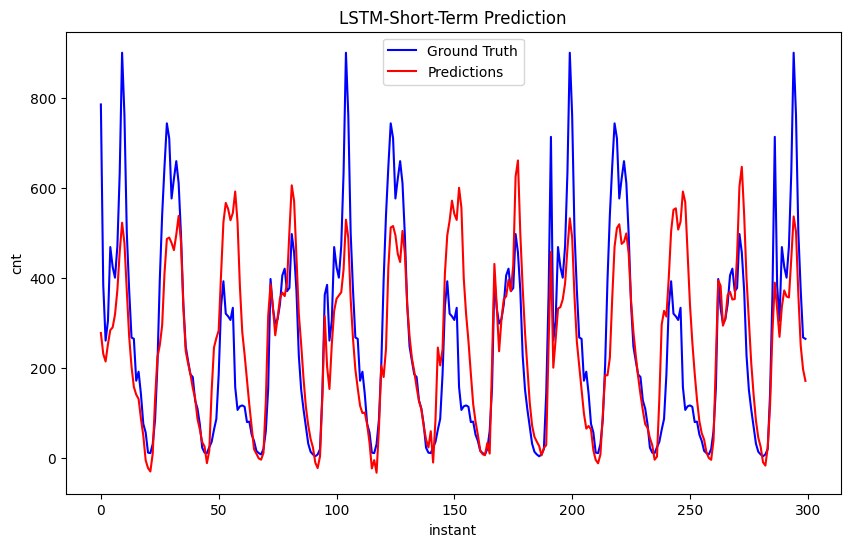

In [190]:
plot_predictions(y_test_short.flatten(), y_pred_short.flatten(), 'LSTM-Short-Term Prediction')

In [191]:
print(y_test_short)
print(y_pred_short)

[[785.]
 [384.]
 [260.]
 ...
 [ 90.]
 [ 61.]
 [ 49.]]
[[277.05945 ]
 [230.76857 ]
 [213.67705 ]
 ...
 [ 53.2005  ]
 [ 29.730251]
 [ 20.330353]]


# 题目要求：长期预测的模型参数不能用于短期预测

In [192]:
model_long = create_lstm_model((sequence_length, 16),long_predict_length)
lstm_model_long, mse_mean_long, mse_std_long, mae_mean_long ,mae_std_long = train(model_long,X_train_long, y_train_long, X_test_long, y_test_long, sequence_length, epochs=10, batch_size=32, num_trials=10 )
print("long prediction:")
print(f"Average MSE: {mse_mean_long} ± {mse_std_long}")
print(f"Average MAE: {mae_mean_long} ± {mae_std_long}")

Trial 1/10
Epoch 1/10


KeyboardInterrupt: 

In [193]:
y_pred_long = lstm_model_long.predict(X_test_long)
y_pred_long = scaler_y_long.inverse_transform(y_pred_long.reshape(-1, 1))
y_test_long = scaler_y_long.inverse_transform(y_test_long.reshape(-1, 1))

58/58 [==============================] - 4s 63ms/step


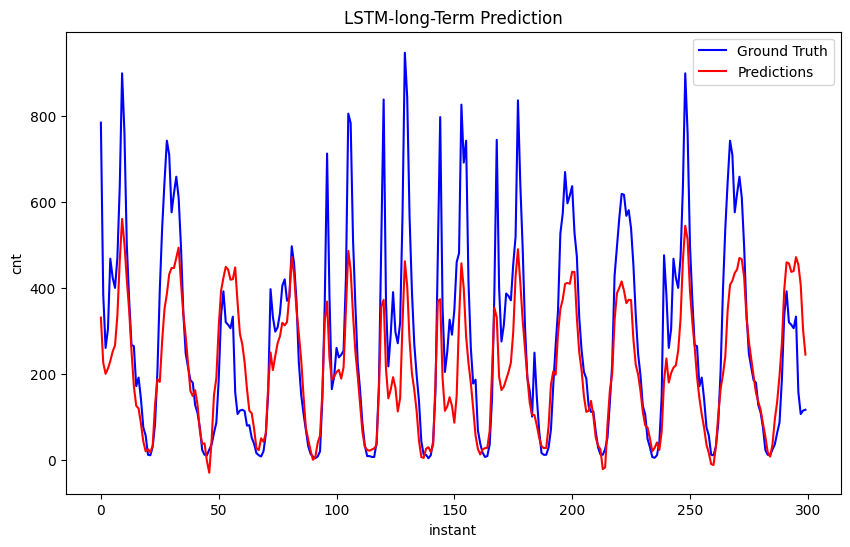

In [182]:
plot_predictions(y_test_long.flatten(), y_pred_long.flatten(), 'LSTM-long-Term Prediction')